In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from textwrap import wrap
from cpnLES_MSCARTlib import DHARMA_onmp,LES_field
import cpnCommonlib as cpn
cpn.setup_figures(plt)


In [14]:
DYCOMS2.DHARMA.dN_drops.shape

(25, 96, 128, 128)

In [15]:
w_tau.shape

(96, 128, 128)

In [28]:
DYCOMS2.dTau.shape

(3, 96, 128, 128)

## Vertically weighted and CER and CEV 
Vertical weighting method based on two-way transmittance (Platnick et. al. 2000, Alexandrove et. al. 2012, Zhang et. al. 2017, Miller et. al. 2016) can be impleted via two approaches. 

#### (1) First, find $r_e(\tau)$ (or $v_e(\tau)$) and user vertical weighting function to get the weighted value, $r_{e,vw}$ 

#### (2) Find the vertically-weighted size distribution $N_{VW}$ and then use to find $r_e$ and $v_e$ \
From Miller et. al.\
$N_{VW}(r)=\int_0^{\tau_{tot}}{N(r,\tau)w(\tau)d\tau}$

Hansen & Travis 1974 2.53 \
$r_{e,Nvw}=\frac{\int{Q_e(r)\omega(r)r^3N_{VW}(r)dr}}{\int{Q_e(r)\omega(r)r^2N_{VW}(r)dr}}$

Hansen & Travis 1974 2.54 \
$v_{e,Nvw}=\frac{1}{r_{e,Nvw}^2}\frac{\int{(r-r_{e,Nvw})^2\pi r^2N_{VW}(r)dr}}{\int{\pi r^2N_{VW}(r)dr}}$

#### Generalized implementation

In [2]:
DYCOMS2_path  ='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/DYCOMS/Ackerman_DYCOMS2_25bins/'
DYCOMS2=DHARMA_onmp('dharma_008036.cdf',DYCOMS2_path );DYCOMS2.readDHARMA()
mie_path='/umbc/xfs1/zzbatmos/users/charaj1/LES_simulations/'
mie_name='DYCOM2_dharma_008036_mie_470_860_2p13'
lesCname='DYCOMS2';lesBinEd=None
a=1;b=0;SZA=40;VZA=0
band=2
wvl={1:'0p860',2:'2p13'}
#Re_vw,Ve_vw,dN_vw,re_tau,ve_tau,w_tau,tau,re_dN_vw,ve_dN_vw=DYCOMS2.find_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)        
DYCOMS2.setup_reVW(mie_name,lesCname,SZA,VZA,a=a,b=b,mie_path=mie_path,band=band)

self.c_mie created!
File name: dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b2p130a1_b0
File already exist in: /umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/


Replace/Reload 1/0: 1


Previous results will be replaced!
self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created
self.zTau, self.zTau0top created.
Calculating re and ve ...
1.83 mins elapsed!
/umbc/xfs1/zzbatmos/users/charaj1/taki/ACRS/LES_simulations/dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b2p130a1_b0.hdf5 SAVED!


#### Test implementation

In [5]:
if lesCname is not None:
    DYCOMS2.setup_dTau(mie_name,lesCname,mie_path=mie_path)
elif lesBinEd is not None:
    DYCOMS2.setup_dTau(mie_name,lesBinEd=lesBinEd,mie_path=mie_path)
if band is None:
    band=2
    print('Deafault wavelength %0.3f being selected'%(DYCOMS2.c_mie.wvl[band]))
    print('Available wavelengths:'+str(self.c_mie.wvl))
DYCOMS2.zTau=np.cumsum(DYCOMS2.dTau,axis=1)
DYCOMS2.zTau0top=np.zeros_like(DYCOMS2.zTau,dtype=float)
for i in np.arange(DYCOMS2.x.size):
    for j in np.arange(DYCOMS2.y.size):
        for wv in np.arange(3):
            DYCOMS2.zTau0top[wv,:,i,j]=DYCOMS2.zTau[wv,-1,i,j]-DYCOMS2.zTau[wv,:,i,j]
print('self.zTau, self.zTau0top created.')
tau=DYCOMS2.zTau0top[band,:]
sza=np.deg2rad(SZA)
vza=np.deg2rad(VZA)
B=1/np.cos(sza)+1/np.cos(vza)
c=1/np.einsum('zxy,zxy->xy',tau**b*np.exp(-a*B*tau),DYCOMS2.dTau[band,:])
#c=1/np.trapz(tau**b*np.exp(-a*B*tau),tau,axis=0)
w_tauDIVc=tau**b*np.exp(-a*B*tau)
num=np.einsum('r,rzxy->rzxy',DYCOMS2.DHARMA.r_drops**3,DYCOMS2.DHARMA.dN_drops)
num=np.trapz(num,DYCOMS2.DHARMA.r_drops,axis=0)
den=np.einsum('r,rzxy->rzxy',DYCOMS2.DHARMA.r_drops**2,DYCOMS2.DHARMA.dN_drops)
den=np.trapz(den,DYCOMS2.DHARMA.r_drops,axis=0)
re_tau=num/den
Re_vw=c*np.einsum('zxy,zxy->xy',re_tau*w_tauDIVc,DYCOMS2.dTau[band,:])
#Re_vw=c*np.trapz(re_tau*w_tauDIVc,tau,axis=0)
w_tau=w_tauDIVc*c

self.c_mie created!
Make sure to give correct lesCname.
self.qe_avg, self.alb_av created
self.zTau, self.zTau0top created.


### Profile analysis

figures/dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b2p130a1_b0_X110Y20.png SAVED.


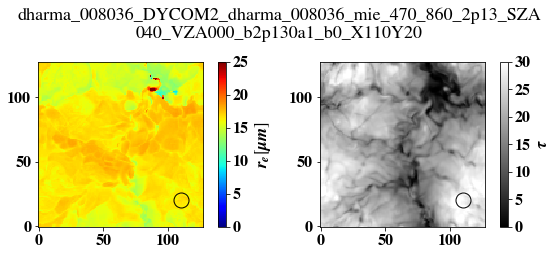

In [18]:
x,y=110,20
fig1,ax1=plt.subplots(1,2,figsize=(8,4),subplot_kw={'aspect':'equal'})
fig1_ttl=DYCOMS2.VW.fname+'_X{}Y{}'.format(x,y)
ctf1=ax1[0].imshow(DYCOMS2.VW.Re,origin='lower',vmin=0,vmax=25,cmap=plt.cm.jet)
ctf2=ax1[1].imshow(DYCOMS2.VW.Tau,origin='lower',vmin=0,vmax=30,cmap=plt.cm.binary_r)
ax1[0].plot(x,y,'ko',markersize=15,markerfacecolor='none')
ax1[1].plot(x,y,'ko',markersize=15,markerfacecolor='none')
cpn.add_cb(fig1,ctf1,ax1[0],orientation='vertical',label=r'$r_e$[$\mu m$]',ticks=np.arange(0,25.1,5))
cpn.add_cb(fig1,ctf2,ax1[1],orientation='vertical',label=r'$\tau$',ticks=np.arange(0,30.1,5))
#ax1[1].tick_params(labelleft=False)
fig1.suptitle("\n".join(wrap(fig1_ttl,55)))
fig1.tight_layout()
cpn.savefig(fig1,fig1_ttl,'figures/')

figures/re_ve_profiles_dharma_008036_DYCOM2_dharma_008036_mie_470_860_2p13_SZA040_VZA000_b2p130a1_b0_X110Y20.png SAVED.


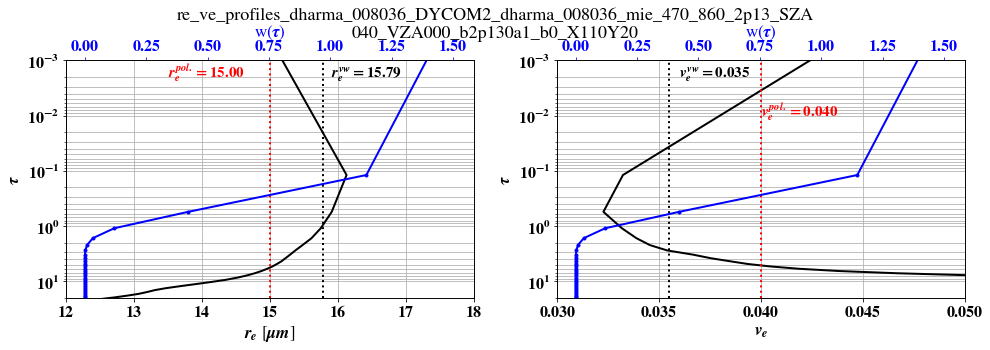

In [17]:
x,y=110,20
fig1,ax1 = plt.subplots(1,2,figsize=(14,5))
fig1_ttl = 're_ve_profiles_'+DYCOMS2.VW.fname+'_X{}Y{}'.format(x,y)
fig1.suptitle("\n".join(wrap(fig1_ttl)))
#CER
ax1[0].plot(DYCOMS2.VW.re_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'k-',label=r'$r_e$($\tau$)')
ax1[0].set_ylabel(r'$\tau$')
ax1[0].set_xlabel(r'$r_e$ [$\mu m$]')
ax1[0].invert_yaxis()
ax1[0].set_xlim(12,18)
ax1[0].set_ylim(20,0.001)
ax1[0].set_yscale('log')
ax1[0].grid(which='both')
ax12 = ax1[0].twiny()
ax12.plot(DYCOMS2.VW.w_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'b.-',label=r'w($\tau$)')
ax12.set_xlabel(r'w($\tau$)',color='b')
ax12.invert_yaxis()
ax12.tick_params(axis='x',colors='blue')
#vertical lines
ax1[0].axvline(DYCOMS2.VW.Re[x,y],ls=':',color='k') # vw CER retrievals
ax1[0].annotate(r'$r_e^{vw}=%0.2f$'%(DYCOMS2.VW.Re[x,y]),xy=[15.9,0.002],color='k')
ax1[0].axvline(15.0,ls=':',color='r')
ax1[0].annotate(r'$r_e^{pol.}=%0.2f$'%(15.0),xy=[13.5,0.002],color='r')
#CEV
ax1[1].plot(DYCOMS2.VW.ve_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'k-',label=r'$v_e$($\tau$)')
ax1[1].set_ylabel(r'$\tau$')
ax1[1].set_xlabel(r'$v_e$')
ax1[1].invert_yaxis()
ax1[1].set_xlim(0.03,0.05)
ax1[1].set_ylim(20,0.001)
ax1[1].set_yscale('log')
ax1[1].grid(which='both')
ax13 = ax1[1].twiny()
ax13.plot(DYCOMS2.VW.w_tau[:,x,y],DYCOMS2.VW.tau[:,x,y],'b.-',label=r'w($\tau$)')
ax13.set_xlabel(r'w($\tau$)',color='b')
ax13.invert_yaxis()
ax13.tick_params(axis='x',colors='blue')
#vertical lines
ax1[1].axvline(DYCOMS2.VW.Ve[x,y],ls=':',color='k') # vw CER retrievals
ax1[1].annotate(r'$v_e^{vw}=%0.3f$'%(DYCOMS2.VW.Ve[x,y]),xy=[0.036,0.002],color='k')
ax1[1].axvline(0.04,ls=':',color='r')
ax1[1].annotate(r'$v_e^{pol.}=%0.3f$'%(0.04),xy=[0.04,0.01],color='r')
fig1.tight_layout(rect=[0,0,1,0.98])
cpn.savefig(fig1,fig1_ttl,'figures/')

In [102]:
DYCOMS2.VW.Ve[x,y]

-0.02447713346149246

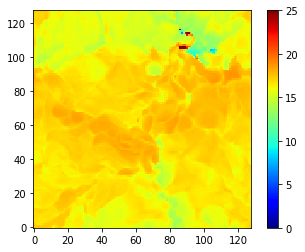

In [14]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(DYCOMS2.VW.Re_dN_vw,origin='lower',vmin=0,vmax=25,cmap=plt.cm.jet)
fig1.colorbar(ctf)

0.04209634467674629


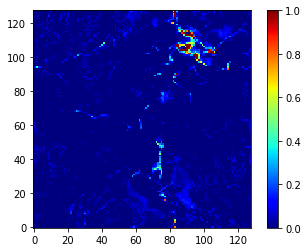

In [90]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(Re_vw-DYCOMS2.VW.Re_dN_vw,origin='lower',vmin=0,vmax=1,cmap=plt.cm.jet)
fig1.colorbar(ctf)
print(np.mean(abs(DYCOMS2.VW.Re-Re_vw)))

Text(0.5, 0, 're')

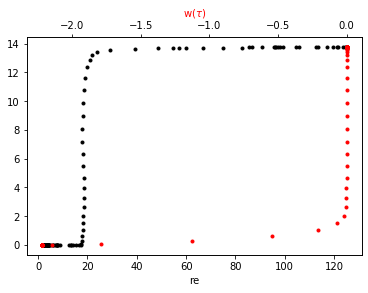

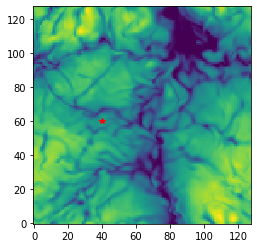

In [27]:
plt.imshow(tau[40,:,:],origin='lower')
plt.plot(40,60,'r*')

/umbc/xfs1/zzbatmos/users/charaj1/taki/softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(array([2.09827709e+19, 2.46856129e+18, 1.23428064e+18, 1.23428064e+18,
        0.00000000e+00, 1.23428064e+18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.23428064e+18, 0.00000000e+00, 0.00000000e+00,
        1.23428064e+18, 0.00000000e+00, 1.23428064e+18]),
 array([0.0000000e+00, 3.2407541e-20, 6.4815081e-20, 9.7222622e-20,
        1.2963016e-19, 1.6203770e-19, 1.9444524e-19, 2.2685278e-19,
        2.5926032e-19, 2.9166786e-19, 3.2407541e-19, 3.5648295e-19,
        3.8889049e-19, 4.2129803e-19, 4.5370557e-19, 4.8611311e-19],
       dtype=float32),
 <a list of 15 Patch objects>)

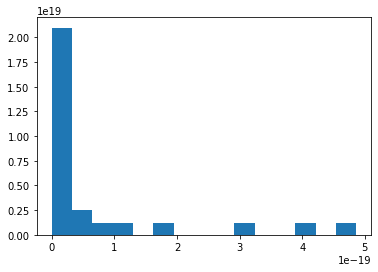

In [13]:
plt.hist(DYCOMS2.DHARMA.dN_drops[:,80,20,20],normed=True,bins=15)

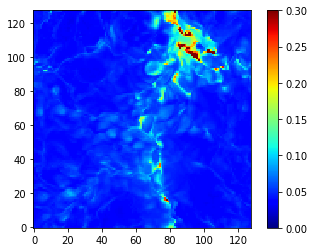

In [7]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(DYCOMS2.VW.Ve_dN_vw,origin='lower',vmin=0,vmax=0.3,cmap=plt.cm.jet)
fig1.colorbar(ctf)

0.00211271035882554


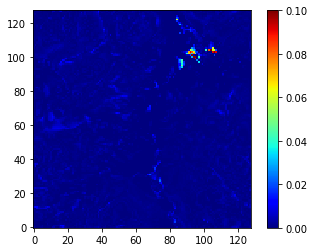

In [11]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(DYCOMS2.VW.Ve-DYCOMS2.VW.Ve_dN_vw,origin='lower',vmin=0,vmax=0.1,cmap=plt.cm.jet)
fig1.colorbar(ctf)
print(np.mean(abs(DYCOMS2.VW.Ve-DYCOMS2.VW.Ve_dN_vw)))

0.09226362520220424


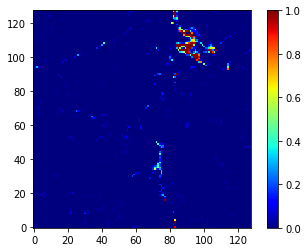

In [90]:
fig1,ax1=plt.subplots()
ctf=ax1.imshow(Re_vw-re_Nvw2,origin='lower',vmin=0,vmax=1,cmap=plt.cm.jet)
fig1.colorbar(ctf)
print(np.mean(abs(Re_vw-re_Nvw2)))

In [11]:
vars(DYCOMS2.VW).keys()



dict_keys(['replace', 'fname', 'mie_path', 'les_onmp', 'fpath', 'Re', 'Ve', 'Re_dN_vw', 'Ve_dN_vw', 'Tau', 'dN', 're_tau', 've_tau', 'w_tau', 'tau', 'x', 'y', 'z'])

In [15]:
vwwt=c*w_tauDIVc

In [13]:
c.shape

(128, 128)

In [16]:
vwwt.shape

(96, 128, 128)